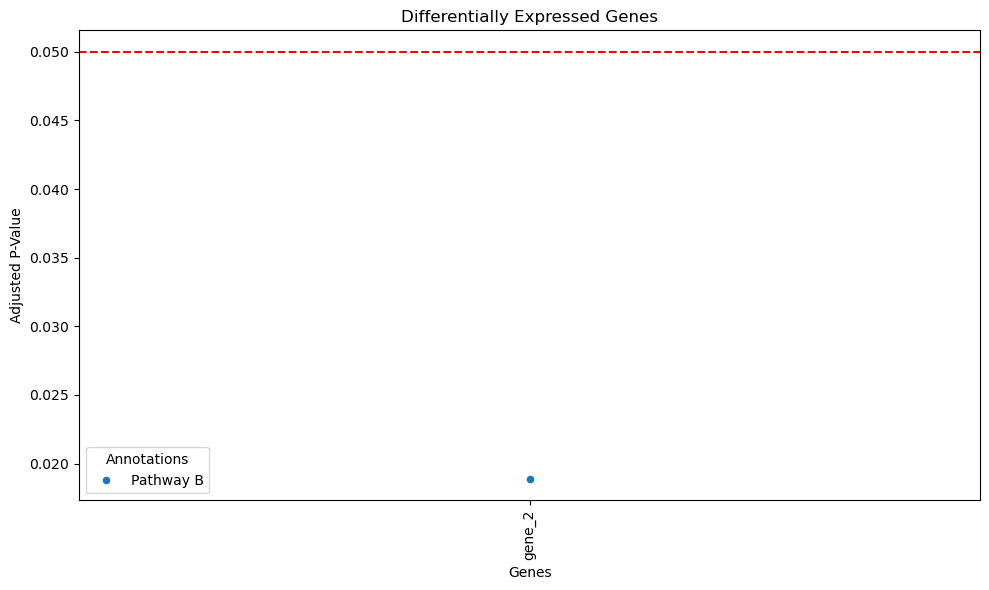

Analysis complete. Results saved to 'differentially_expressed_genes.csv' and 'RNASeq_Analysis_Report.txt'.


In [2]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Suppressing warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Setting a random seed for reproducibility
np.random.seed(42)

# Creating a list of gene names (gene_1 to gene_100)
genes = [f'gene_{i}' for i in range(1, 101)]
# Defining conditions for the experiment (Control and Treatment)
conditions = ['Control', 'Treatment']
# Creating sample names (sample_1 to sample_10)
samples = [f'sample_{i}' for i in range(1, 11)]

# Generating a random dataset of gene expression using Poisson distribution
data = np.random.poisson(lam=20, size=(100, 10))

# Adding 15 to a subset of the data to simulate treatment effect
data[:5, 5:10] += 15

# Creating a DataFrame to hold the gene expression data
df = pd.DataFrame(data, index=genes, columns=samples)

# Creating a metadata DataFrame to hold sample conditions
metadata = pd.DataFrame({
    'sample': samples,
    'condition': ['Control'] * 5 + ['Treatment'] * 5  # First 5 samples are Control, next 5 are Treatment
})

# Normalizing the data to counts per million (CPM)
df_norm = df.div(df.sum(axis=0), axis=1) * 1e6

# Log-transforming the normalized data for better statistical properties
df_log = np.log2(df_norm + 1)

# Function to perform differential expression analysis
def differential_expression(df_log, metadata):
    results = []  # Initialize a list to store results
    # Loop over each gene in the log-transformed DataFrame
    for gene in df_log.index:
        y = df_log.loc[gene].values  # Get the expression values for the gene
        X = pd.get_dummies(metadata['condition'], drop_first=True)  # Create dummy variables for condition
        X = sm.add_constant(X.astype(float))  # Add a constant term for the intercept
        
        # Fit an Ordinary Least Squares (OLS) regression model
        model = sm.OLS(y, X).fit()
        p_value = model.pvalues[1]  # Extract the p-value for the treatment effect
        results.append({'gene': gene, 'p_value': p_value})  # Store the gene and its p-value in results
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    # Adjust p-values for multiple testing using Benjamini-Hochberg method
    results_df['adjusted_p_value'] = sm.stats.multipletests(results_df['p_value'], method='fdr_bh')[1]
    return results_df  # Return the results DataFrame

# Perform differential expression analysis
results_df = differential_expression(df_log, metadata)

# Filter for differentially expressed genes (DEGs) with adjusted p-value < 0.05
deg = results_df[results_df['adjusted_p_value'] < 0.05]

# Create a dictionary for functional annotations of selected genes
annotations = {
    'gene_1': 'Pathway A',
    'gene_2': 'Pathway B',
    'gene_3': 'Pathway C',
    'gene_4': 'Pathway D',
    'gene_5': 'Pathway E',
}

# Map annotations to the differentially expressed genes
deg['annotation'] = deg['gene'].map(annotations).fillna('Unknown')

# Plotting the results
plt.figure(figsize=(10, 6))  # Set the figure size
sns.scatterplot(x='gene', y='adjusted_p_value', hue='annotation', data=deg)  # Create a scatter plot
plt.axhline(y=0.05, color='r', linestyle='--')  # Add a horizontal line at p-value = 0.05
plt.xlabel('Genes')  # Label for the x-axis
plt.ylabel('Adjusted P-Value')  # Label for the y-axis
plt.title('Differentially Expressed Genes')  # Title of the plot
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend(title="Annotations")  # Legend title
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()  # Display the plot

# Save the differentially expressed genes to a CSV file
deg.to_csv('differentially_expressed_genes.csv', index=False)

# Creating a report for the RNA-Seq analysis
report = """
RNA-Seq Data Analysis Report
============================
Differentially Expressed Genes:
{}

Functional Annotations:
{}

Potential Biological Interpretations:
- The genes such as gene_1, gene_2, etc., are involved in pathways A, B, etc.
These pathways are important for understanding the effect of the treatment condition.
""".format(deg[['gene', 'adjusted_p_value']], deg[['gene', 'annotation']])

# Writing the report to a text file
with open('RNASeq_Analysis_Report.txt', 'w') as f:
    f.write(report)

# Informing the user that the analysis is complete and files are saved
print("Analysis complete. Results saved to 'differentially_expressed_genes.csv' and 'RNASeq_Analysis_Report.txt'.")
